# CNN - ThermalConductivity

This is used for CIV_ENG_426-2 final project.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, optimizers, backend
from tensorflow.keras.models import Sequential
from keras.layers import core, convolutional, pooling, BatchNormalization

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


References

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/api/preprocessing/image/

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://keras.io/api/metrics/

https://navoshta.com/end-to-end-deep-learning/

https://keras.rstudio.com/reference/evaluate.html

# 1 Data processing

### Read image and effective kappa.

In [3]:
# pics
x = np.empty([0, 176, 176, 3], dtype=np.float32)
for meshnum in [10, 20, 30, 40, 50, 60]:
    for k in range(1,101):
        image = mpimg.imread(f'picdata/{meshnum}_{k}.png')
        x = np.append(x, [image], axis=0)

In [4]:
# effective kappa
y = np.empty([0], dtype=np.float32)
for meshnum in [10, 20, 30, 40, 50, 60]:
    flux_file = f'txtdata/effk_mesh{meshnum}.txt'
    flux = np.array(np.genfromtxt(flux_file, delimiter='\t', skip_header=0))
    for k in range(1,101):
        effek = -flux[k-1,4]
        y = np.append(y, [effek])

In [5]:
np.shape(x)

(600, 176, 176, 3)

In [6]:
np.shape(y)

(600,)

### Split data

- Generate new data sequence

In [ ]:
# n_list = np.arange(600)
# np.random.shuffle(n_list)

In [245]:
# # Save shuffled sequence to reproduce result
# np.savez("trained/dataseq", n_list=n_list)

- Read previous sequence

In [250]:
npzfile = np.load("trained/dataseq.npz")
n_list = npzfile['n_list']

In [211]:
num_train = 400   # 67%
num_valid = 160   # 27%
num_test = 40    # 6%
num_total = num_train + num_test + num_valid

n_train = n_list[:num_train]
n_valid = n_list[num_train:(num_train+num_valid)]
n_test = n_list[(num_train+num_valid):num_total]

In [212]:
xtrain, ytrain = x[n_train], y[n_train]
xvalid, yvalid = x[n_valid], y[n_valid]
xtest, ytest = x[n_test], y[n_test]

### Image generator

In [213]:
# construct the training image generator for data augmentation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# standardization based on training data
datagen.fit(xtrain)

In [214]:
BS = 32
num_epoch = 20

In [215]:
# training
train_generator = datagen.flow(xtrain, ytrain, batch_size=BS, shuffle=False)
valid_generator = datagen.flow(xvalid, yvalid, batch_size=BS, shuffle=False)
# testing
test_generator = datagen.flow(xtest, ytest, batch_size=num_test, shuffle=False)

# 2 CNN

### CNN architecture

In [216]:
# Model architecture
model = models.Sequential()
model.add(convolutional.Convolution2D(16, (3, 3), input_shape=(176, 176, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(convolutional.Convolution2D(32, (3, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(convolutional.Convolution2D(32, (3, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(core.Flatten())
model.add(core.Dense(500, activation='relu'))
model.add(core.Dropout(.5))
model.add(core.Dense(20, activation='relu'))
model.add(core.Dense(1))

In [217]:
model.compile(optimizer=optimizers.adam(lr=1e-04), 
              loss='mse', 
              metrics=[metrics.RootMeanSquaredError()])

In [218]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 174, 174, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 87, 87, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12800)           

### Training

- Option 1: read saved weights from previous training

In [219]:
model.load_weights("trained/CNN.h5")

- Option 2: train a new model

In [220]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=len(xtrain)//BS,
                    epochs=num_epoch,
                    validation_data=valid_generator, verbose=1)

Epoch 1/20
12/12 [==============================] - 28s 2s/step - loss: 26.4478 - root_mean_squared_error: 6.5099 - val_loss: 4.0651 - val_root_mean_squared_error: 4.5525
Epoch 2/20
12/12 [==============================] - 9s 759ms/step - loss: 7.4302 - root_mean_squared_error: 3.9897 - val_loss: 3.3971 - val_root_mean_squared_error: 3.6144
Epoch 3/20
12/12 [==============================] - 7s 621ms/step - loss: 4.3109 - root_mean_squared_error: 3.3484 - val_loss: 0.8956 - val_root_mean_squared_error: 3.1165
Epoch 4/20
12/12 [==============================] - 7s 547ms/step - loss: 2.3028 - root_mean_squared_error: 2.9428 - val_loss: 0.7483 - val_root_mean_squared_error: 2.7804
Epoch 5/20
12/12 [==============================] - 7s 542ms/step - loss: 1.8936 - root_mean_squared_error: 2.6528 - val_loss: 0.6489 - val_root_mean_squared_error: 2.5423
Epoch 6/20
12/12 [==============================] - 7s 544ms/step - loss: 1.8391 - root_mean_squared_error: 2.4483 - val_loss: 0.2922 - val_r

In [253]:
# model.save_weights("trained/CNN.h5")

Loss and RMSE

In [233]:
# history.history['loss']

In [234]:
# history.history['root_mean_squared_error']

In [235]:
# history.history['val_loss']

In [236]:
# history.history['val_root_mean_squared_error']

<IPython.core.display.Javascript object>


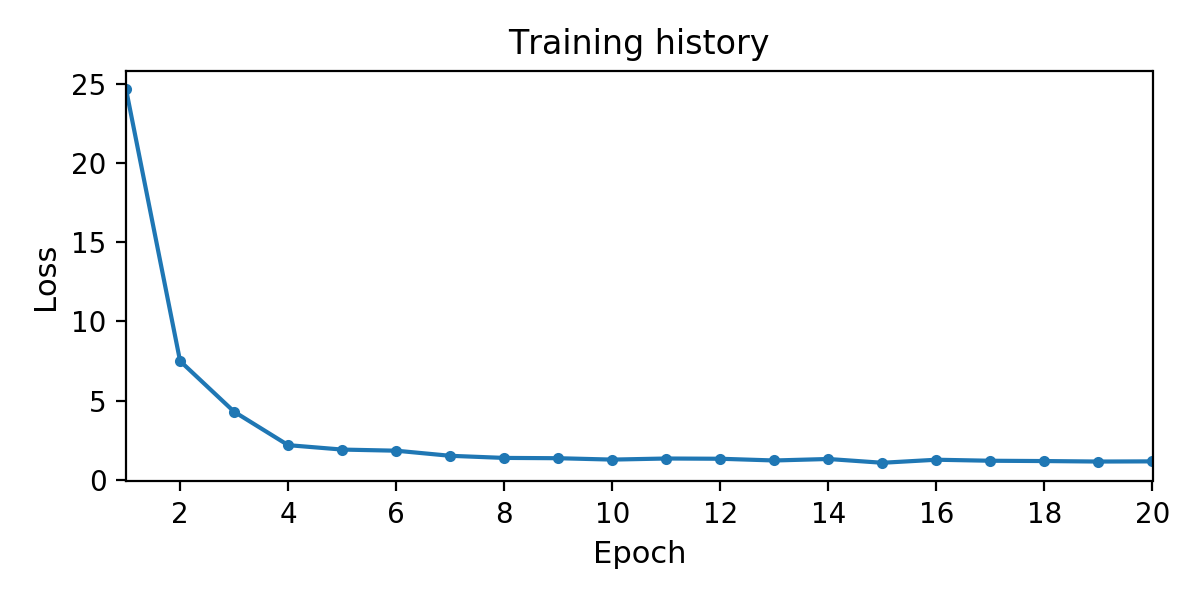

In [226]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111)

epoch_no = np.arange(1, num_epoch+1)
epoch_no2 = epoch_no[1::2]
plt.plot(epoch_no, history.history['loss'], '.-', label='training loss')
plt.xlim(1, num_epoch)
plt.xlabel('Epoch', fontsize=11)
plt.xticks(epoch_no2,epoch_no2)
plt.ylabel('Loss', fontsize=11)
plt.title('Training history',fontsize=12)
plt.tight_layout()
plt.show()

## Testing

- Evaluate

In [227]:
loss, RMSE = model.evaluate_generator(test_generator, 
                                        steps=1, 
                                        use_multiprocessing=True, 
                                        workers=1,
                                        verbose=0)

In [228]:
loss

0.037720389664173126

In [229]:
RMSE

1.525068759918213

In [230]:
NRMSE = RMSE/(np.linalg.norm(ytest)/np.sqrt(num_test))

In [231]:
print("Model testing NRMSE: {0:.2f}%".format(NRMSE*100))

Model testing NRMSE: 13.61%


- Predict

In [237]:
ytest_predict = model.predict_generator(test_generator, steps=1, verbose=0)

In [238]:
ytest_predict.flatten()

array([11.069579 , 15.527868 , 16.866959 ,  4.615352 , 14.911559 ,
        6.055785 , 10.944011 ,  4.745542 , 12.712724 ,  4.394321 ,
        2.5468123, 14.328893 , 14.734652 ,  6.714255 ,  6.0343285,
        1.1752706,  5.5172534,  4.6162457,  4.1218405, 14.221034 ,
        9.043823 , 12.1482115,  5.116435 , 16.30634  ,  3.215543 ,
       15.84024  , 11.366306 ,  4.5316434, 15.084325 , 12.871247 ,
        6.8819785, 16.638788 ,  3.9569166, 10.884239 , 14.154206 ,
       14.28637  , 13.410768 , 16.577337 ,  3.0978725, 14.9367895],
      dtype=float32)

In [239]:
ytest

array([11.18682 , 15.720993, 16.940838,  4.567205, 15.203247,  6.22723 ,
       11.002805,  4.549063, 13.079348,  4.214058,  2.294082, 14.617848,
       14.884922,  6.920639,  6.355564,  1.      ,  5.452304,  4.60849 ,
        4.043137, 14.433969,  8.868427, 12.228884,  5.07195 , 16.564141,
        3.326288, 16.172159, 11.514024,  4.382594, 15.33563 , 13.23001 ,
        7.042883, 16.766628,  3.904551, 11.116214, 14.287261, 14.277199,
       13.445563, 16.948078,  3.135283, 14.876787])